In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import savemat

In [2]:
gamma = 1.5
cmap='nipy_spectral'

res_path = 'project'  
dat_path = 'results'
scene_name = 'bunny'
gamma_diag = 2.2

In [3]:
def norm_im(im, blk, wht):
    im = (im - blk)/(wht - blk)
    im[im<0] = 0
    im[im>1] = 1
    return im

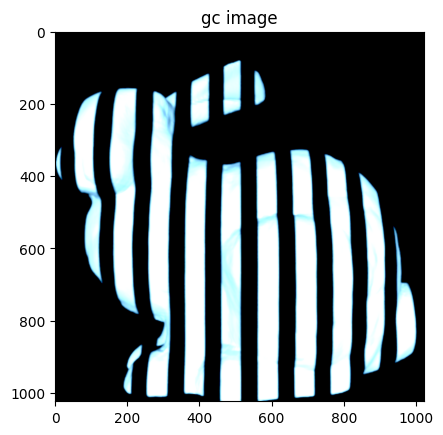

True

In [4]:
blk_lev = 0.065
wht_lev = 0.5
gamma_vis = 2.2
R = 1024
C = 1024

im_gc = 1*cv2.imread(os.path.join(dat_path, 'result_pattern_13.png'))/255
im_gc = cv2.resize(im_gc, (C,R))
im_gc_vis = norm_im(im_gc, blk_lev, wht_lev)
im_gc_vis = im_gc_vis**(1/gamma_vis)
plt.imshow(im_gc_vis[...,::-1])
plt.title('gc image')
plt.show()
cv2.imwrite(os.path.join(res_path, 'im_gc.png'), 256*(im_gc**(1/gamma_vis)))
cv2.imwrite('im_gc.png', 256*(im_gc_vis))

In [9]:
def read_epi_gc(dat_path, prefix):
    N_gc = 38 # number of graycode images
    fsize = 3

    # load captured patterns
    cap_full = []
    for i in range(N_gc):
        fn = os.path.join(dat_path, '%s_%02d.png'%(prefix, i))
        im_full = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        im_full = ndimage.median_filter(im_full, size=fsize)
        cap_full.append(im_full)
    return cap_full

def estimate_depth_graycode(cap_full):
    # parameters
    cam_shape = (360, 360) # row, column
    proj_shape = (360, 360) # row, column
    N_gc = 38 # number of graycode images
    N_tot = N_gc  # number of capture images (graycode + white + black)
    gc_step = 1 # should be 1 
    black_thr = 0
    white_thr = 0
    
    # captured patterns
    cap = []
    for cap_full_i in cap_full:
        im = np.zeros(cam_shape).astype(np.uint8)
        im = cap_full_i
        cap.append(im)
        
    # prepare simulation patterns
    gc_height = int((proj_shape[0]-1)/gc_step)+1    
    gc_width = int((proj_shape[1]-1)/gc_step)+1
    graycode = cv2.structured_light_GrayCodePattern.create(gc_width, gc_height)
    graycode.setBlackThreshold(black_thr)
    graycode.setWhiteThreshold(white_thr)
    
    R,C = im.shape
    
    # estimate the correspondence map
    corr = np.zeros((cam_shape[0], cam_shape[1], 2))
    cam_pts = []
    prj_pts = []
    valid_mask = np.zeros(cam_shape)
    for r in range(cam_shape[0]):
        if r%180  == 0:
            print('decoding %.2f'%(r/cam_shape[0]))
        for c in range(cam_shape[1]):
            err, proj_pix = graycode.getProjPixel(cap, c, r)
            if not err:
                corr[r,c] = np.array(proj_pix)
                cam_pts.append((c,r))
                prj_pts.append((proj_pix[0],proj_pix[1]))
                valid_mask[r,c] = True
    # plt.imshow(corr[:,:,0])
    # plt.colorbar()
    # plt.show()
    fig, ax = plt.subplots(2, 1, figsize=(5, 10))
    ax[0].imshow(corr[:,:,0], cmap='gray')
    ax[0].set_title("imshow(corr[:,:,0], cmap='gray')")
    ax[1].imshow(corr[:,:,1], cmap='gray')
    ax[1].set_title("imshow(corr[:,:,1], cmap='gray')")
    #vis
    # load the geometric calibration data
    # camproj_calib_path = '/projects/FHEIDE/polar/captured_data_cam_prj/calibration_procam.xml'
    # fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
    img_shape = (360,360)
    cam_int = np.array([[0.7356, 0, 180], [0, 0.7356, 180], [0, 0, 1]], dtype=np.float32)
    # cam_int = [[0.7356, 0, 180], [0, 0.7356, 180], [0, 0, 1]] ##camera intrinsic, f = 25.6mm
    # cam_dist = [0, 0, 0, 0, 0]
    cam_dist = np.array([0, 0, 0, 0, 0], dtype=np.float32)

    # proj_int = [[1036.4638, 0, 179.5], [0, 1036.4638, 179.5], [0, 0, 1]]
    # proj_int = np.array([[1036.4638, 0, 179.5], [0, 1036.4638, 179.5], [0, 0, 1]])
    proj_int = np.array([[360/(2*np.tan(45*np.pi/360)) , 0, 360/2],
                     [0, 360/(2*np.tan(45*np.pi/360)), 360/2],
                     [0, 0, 1]])
    
    # proj_dist = [0, 0, 0, 0, 0]
    proj_dist = np.array([0, 0, 0, 0, 0], dtype=np.float32)
    # cam_proj_rmat = [[0.9961946981, -0.0871557427, 0.0000000000, 0.0000000000],
    #              [0.0000000000, 0.0000000000, -1.0000000000, 0.0000000000],
    #              [0.0871557427, 0.9961946981, 0.0000000000, 0.0000000000],
    #              [0.0000000000, 0.0000000000, 0.0000000000, 1.0000000000]] # eye(4)
    cam_proj_rmat = np.array([[-4.34558441e+02,  1.29162580e+01, -1.79535978e+02],
                                [ 0.00000000e+00,  4.46354451e+02, -1.48353373e+02],
                                [ 0.00000000e+00,  7.17569888e-02, -9.97422099e-01]])
   
    cam_proj_tvec = [1, 0, 0]
    cam_proj_tvec = np.array([1, 0, 0]).reshape((3, 1))

    # undistort points using calibration
    cam_pts = np.array(cam_pts, dtype=np.float32) 
    cam_pts = cam_pts.reshape((-1, 1, 2))
    cam_pts_n = cv2.undistortPoints(cam_pts, cam_int, cam_dist, P=cam_int)
    prj_pts = np.array(prj_pts, dtype=np.float32) 
    prj_pts = prj_pts.reshape((-1, 1, 2))
    prj_pts_n = cv2.undistortPoints(prj_pts, proj_int, proj_dist, P=proj_int)
    
    # triangulate
    P0 = np.dot(cam_int, np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0]]))
    P1 = np.concatenate((np.dot(proj_int, cam_proj_rmat), np.dot(proj_int,cam_proj_tvec)), axis = 1)
    triang_res = cv2.triangulatePoints(P0, P1, cam_pts_n, prj_pts_n)
    points_3d = cv2.convertPointsFromHomogeneous(triang_res.T).squeeze()
    
    # xyz 
    cam_pts = cam_pts.astype(int)
    xyz = np.zeros((R,C,3))
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 0]=points_3d[:,0]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 1]=points_3d[:,1]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 2]=points_3d[:,2]
    xyz = xyz
    
    return xyz

In [10]:
im = read_epi_gc("results", 'resultfar_pattern')


decoding 0.00
decoding 0.50


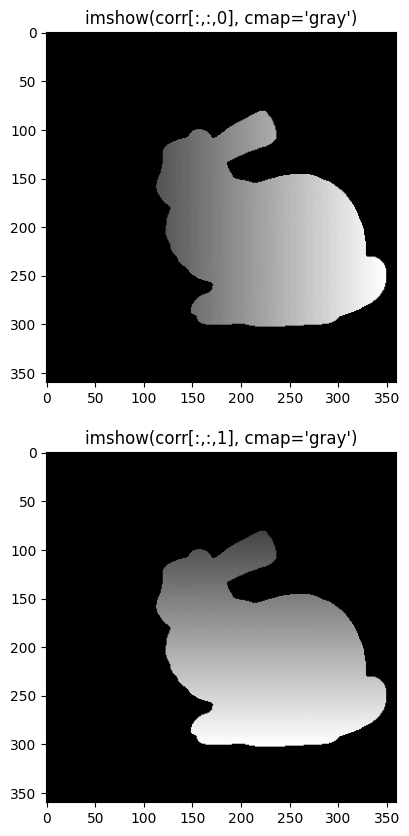

In [11]:
dmap_SL = estimate_depth_graycode(im)


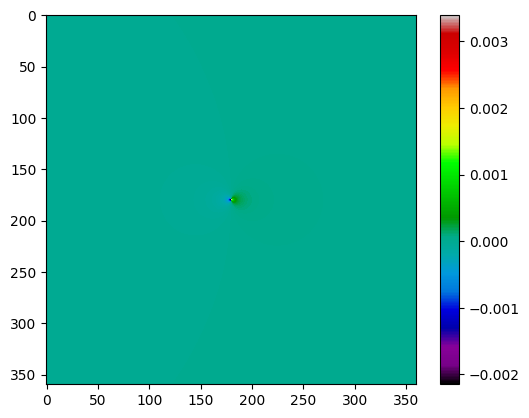

In [12]:
plt.imshow(dmap_SL[...,2], cmap=cmap)
plt.colorbar()
# plt.savefig(os.path.join(res_path,'dmap_SL.svg'))
plt.show()
# savemat('dmap_SL.mat', {'dmap_SL':dmap_SL})